# Predicting Podcast Listening Time
This notebook implements a machine learning pipeline to predict the `Listening_Time_minutes` of podcasts based on the provided dataset. The steps include data loading, exploratory data analysis, preprocessing, feature engineering, model training, evaluation, and hyperparameter tuning.

## Step 1: Initial Setup and Data Loading
Load the dataset and required libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('train.csv')

# Display first few rows
df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


## Step 2: Exploratory Data Analysis (EDA)
Understand the data structure, missing values, and distributions.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


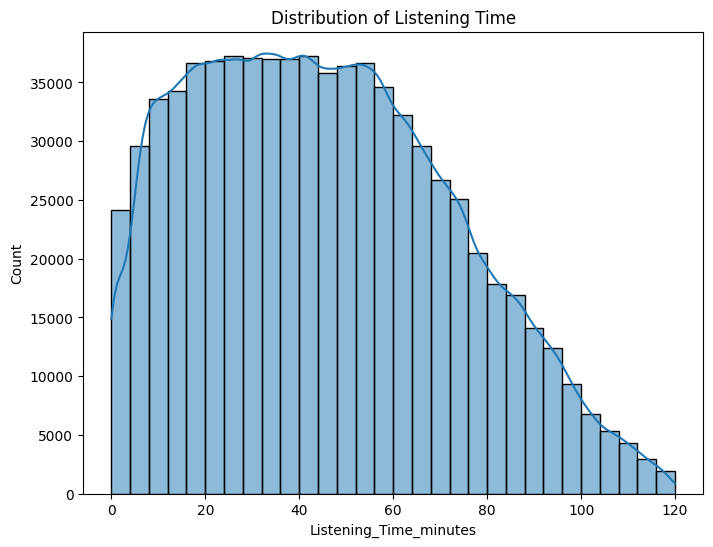

ValueError: could not convert string to float: 'Mystery Matters'

<Figure size 1000x800 with 0 Axes>

In [2]:
# Check dataset info
df.info()

# Check for missing values
print(df.isnull().sum())

# Summary statistics
df.describe()

# Visualize distribution of target variable
plt.figure(figsize=(8, 6))
sns.histplot(df['Listening_Time_minutes'], bins=30, kde=True)
plt.title('Distribution of Listening Time')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Step 3: Data Preprocessing
Handle missing values, encode categorical variables, and scale numerical features.

In [ ]:
# Separate features and target
X = df.drop(['id', 'Listening_Time_minutes'], axis=1)
y = df['Listening_Time_minutes']

# Identify categorical and numerical columns
categorical_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 
                    'Publication_Time', 'Episode_Sentiment']
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                 'Guest_Popularity_percentage', 'Number_of_Ads']

# Handle missing values
# Numerical: Impute with median
num_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Categorical: Impute with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Encode categorical variables
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Verify preprocessing
X.head()

## Step 4: Feature Engineering
Create new features to enhance model performance.

In [ ]:
# Feature: Ratio of Host to Guest Popularity
X['Host_Guest_Popularity_Ratio'] = X['Host_Popularity_percentage'] / (X['Guest_Popularity_percentage'] + 1e-6)

# Feature: Episode Length per Ad
X['Length_per_Ad'] = X['Episode_Length_minutes'] / (X['Number_of_Ads'] + 1e-6)

# Feature: Is Weekend Publication
X['Is_Weekend'] = X['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)

# Check new features
X[['Host_Guest_Popularity_Ratio', 'Length_per_Ad', 'Is_Weekend']].head()

## Step 5: Train-Test Split
Split the data to evaluate model performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training set size: {X_train.shape}, Test set size: {X_test.shape}')

## Step 6: Model Selection and Training
Try multiple regression models and compare performance.

In [ ]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {'MSE': mse, 'R2': r2}
    
    print(f'{name} - MSE: {mse:.2f}, R2: {r2:.2f}')

# Cross-validation for best model (e.g., XGBoost)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f'XGBoost CV R2: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}')

## Step 7: Hyperparameter Tuning
Improve the best model (XGBoost) using Grid Search.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best R2 Score: {grid_search.best_score_:.2f}')

# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f'Tuned XGBoost - MSE: {mean_squared_error(y_test, y_pred):.2f}, R2: {r2_score(y_test, y_pred):.2f}')

## Step 8: Feature Importance
Understand which features drive predictions.

In [ ]:
# Feature importance for XGBoost
best_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

## Step 9: Final Model and Saving
Train the final model on the entire dataset and save it.

In [ ]:
# Train final model on full data
final_model = XGBRegressor(**grid_search.best_params_, random_state=42)
final_model.fit(X, y)

# Save model
import joblib
joblib.dump(final_model, 'podcast_listening_time_model.pkl')
print('Model saved as podcast_listening_time_model.pkl')

## Step 10: Example Prediction
Make a prediction on a new sample.

In [ ]:
# Example new data point
new_data = X.iloc[0:1].copy()
new_pred = final_model.predict(new_data)
print(f'Predicted Listening Time: {new_pred[0]:.2f} minutes')